In [1]:
import numpy as np
import torch
import time
import datetime
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import * # for pad_sequence and whatnot
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler, SequentialSampler

from torch.utils import data
from torchvision import transforms

import matplotlib.pyplot as plt
import time

import json

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import logging
logging.basicConfig(level=logging.INFO)

from train_test import train, test
from preprocessing import PreprocessedData_wordlevel


cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ubuntu/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
INFO:transformers.configuration_utils:Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_nor

7146 7146


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ubuntu/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
INFO:transformers.configuration_utils:Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_nor

torch.Size([7146, 1])
torch.LongTensor
4,287 training samples
2,859 validation samples


INFO:transformers.modeling_utils:Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
INFO:transformers.modeling_utils:Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


======== Epoch 1 / 4 ========
  Batch 40  of  67.    Elapsed: 24.40 seconds
  Average training loss: 0.68
  Average training acc: 0.56
  Training took: 41.01 seconds
  Validation Loss: 0.66
  Validation Accuracy: 0.61
  Validation took: 9.56 seconds
======== Epoch 2 / 4 ========
  Batch 40  of  67.    Elapsed: 25.21 seconds
  Average training loss: 0.64
  Average training acc: 0.64
  Training took: 42.61 seconds
  Validation Loss: 0.64
  Validation Accuracy: 0.63
  Validation took: 10.12 seconds
======== Epoch 3 / 4 ========
  Batch 40  of  67.    Elapsed: 26.00 seconds
  Average training loss: 0.57
  Average training acc: 0.71
  Training took: 43.51 seconds
  Validation Loss: 0.65
  Validation Accuracy: 0.64
  Validation took: 10.18 seconds
======== Epoch 4 / 4 ========
  Batch 40  of  67.    Elapsed: 25.95 seconds
  Average training loss: 0.47
  Average training acc: 0.78
  Training took: 43.51 seconds
  Validation Loss: 0.70
  Validation Accuracy: 0.63
  Validation took: 10.22 secon

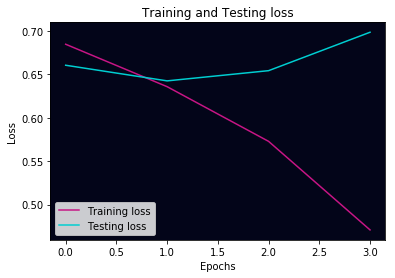

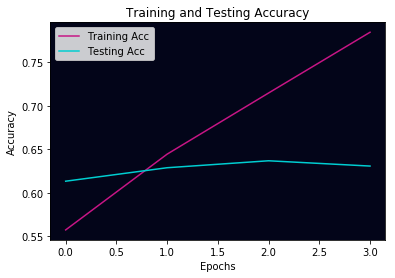

Training complete!
Total training took 210.96 seconds


In [2]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):
    BCK = (3/255, 5/255, 25/255)
    fig, ax = plt.subplots()
    ax.set_facecolor(BCK)
    ax.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    ax.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    ax.set_title(name_long)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(name_short)
    ax.legend()
    plt.show()
    
def run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs):
    start_time = time.time()

    train_losses, train_accs = [], []
    test_losses, test_accs = [] , []
    epochs_l = []
    
    for epoch_i in range(0, epochs):
        print('======== Epoch %d / %d ========' % (epoch_i + 1, epochs))

        train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc = test(model, validation_dataloader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        epochs_l.append(epoch_i)
        
    # Draw Graphs
    make_graph(epochs_l, train_losses, test_losses, 'Training loss', 'Testing loss',
                   'Training and Testing loss', 'Loss')
    make_graph(epochs_l, train_accs, test_accs, 'Training Acc', 'Testing Acc',
                   'Training and Testing Accuracy', 'Accuracy')

    print("Training complete!")
    print("Total training took %.2f seconds" % (time.time()-start_time))

def main():
    MODEL_NAME = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    dataset = PreprocessedData_wordlevel(["./data/architecture_dz-cleaned-tagged.json",
                            "./data/design_dz-cleaned-tagged.json",
                           "./data/technology_dz-cleaned-tagged.json", ], 
                           ["./data/architecture_dz-cleaned.json", 
                            "./data/design_dz-cleaned.json",
                           "./data/technology_dz-cleaned.json"], tokenizer)
    
    train_dataset = dataset.train_dataset
    dev_dataset = dataset.dev_dataset
    
    # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
    batch_size = 32

    # We'll take training samples in random order. 
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

    validation_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=batch_size)
    
    # Load BertForSequenceClassification, the pretrained BERT model with a single 
    # linear classification layer on top. 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",          # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2,               # The number of output labels--2 for binary classification. 
        output_attentions = False,    # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.to(device)
    
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    # The BERT authors recommend between 2 and 4. 
    epochs = 4

    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs)
    
main()